## Common Class

In [24]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import pkg_resources
# pkg_resources.require("numpy==1.23.3")
# pkg_resources.require("pandas==1.5.0")
import seaborn as sns
import itertools
from tqdm import tqdm
import pickle
import os
from time import time
from dateutil.relativedelta import relativedelta
from datetime import datetime

from ta.utils import dropna
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator
load = True

In [92]:
class Common_Class():

    def __init__(self, symbol, start, end, interval, capital, transcation_cost, benchmark,verbose,stock_data_dict,benchmark_df):        
        #new dicts as now there will be multiple stocks. Each stock will have its own position/quantity etc
        self.symbol = symbol
        self.all_data = {stock:pd.DataFrame() for stock in self.symbol}
        self.position = {stock:0 for stock in self.symbol}
        self.quantity = {stock:0 for stock in self.symbol}
        for stock in symbol:
            self.quantity['{}'.format(stock)] = 0 #can also do at run strategy, but its different design
        self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.trades = 0 # Number of trades
        self.verbose = verbose # if you want to see detailed output (logs)
        self.benchmark = benchmark
        self.prepare_data() # prepares the data
        
    def prepare_data(self):
        # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
        # we will calculate the returns though.
        # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.
        # Get the data for all the tickers
        self.all_data = stock_data_dict
        self.benchmark_df = benchmark_df
    
    def close_graph(self, ticker):
        plt.figure(figsize=(15, 5))
        plt.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(ticker))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, bar, stock, price_type = 'Close'): #now we will also pass the stock as parameter
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        i = str(stock)
        date = str(self.all_data[i].index[bar])[:10]  # :10 to only get the date
        if (price_type == "Close"): price = self.all_data[i].Close_Price.iloc[bar]
        elif (price_type == "Open"): price = self.all_data[i].Open_Price.iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #returns the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
        print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

    def unrealised_balance(self, bar):
        #returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        tb = ub + self.capital
        #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
        return tb

    def store_results(self, trade, date, position, price, symbol, quantity, capital):
        trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
        self.stored_data = pd.concat([self.stored_data, trade_detail])

    def performance_plots(self):# once we have dataframe of daily account balances
        Final_result_data = self.Final_result_data #saving time to write self everywhere
        interval = str(self.interval)
        f,ax = plt.subplots(2,3,figsize=(20,10))

        #plot 1: Close Price os stock
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log returns of included stocks")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 2: Histogram of dtrstegy returns
        plt.subplot(2, 3, 2)
        plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
        plt.title("Histogram of Strategy returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 3: Strategy vs Instrument
        plt.subplot(2, 3, 3)
        plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
        plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
        plt.title("Strategy Vs Stock Cum Return Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 4: Drawdown
        plt.subplot(2, 3, 4)
        plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
        plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
        plt.title("Drawdown")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 5: Equity Curve
        plt.subplot(2, 3,  5)
        plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
        plt.title("Equity Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        plt.suptitle("Performance Plots")
        f.delaxes(ax[1,2]) # to delete the last subplot

        plt.show()

    def performance(self,tuning):
        # stored data has  [trade, date, position, price, symbol, quantity, capital]
        #B = self.stored_data # this will have many rows ; n(number of instruments) times more
        #C = self.all_data # will need this to aggregate the returns from all stocks
        #B.index = range(B.shape[0]/len(self.symbol))

        #Since the stocks are not stored in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
        #stored data has many rows, we will aggregate day wise

        df = pd.DataFrame() # creating a new datframe to store aggregated values

        df['capital'] = self.total_balance_df
        #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

        trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
        trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

        #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

        for stock in self.symbol:
            df['Returns_{}'.format(stock)] = self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()
        c= df.columns #fetch all the columns of datframe
        df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
        df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
        df.index = range(df.shape[0])

        df['capital_after_settlement'] = df['capital'].shift(-1)

        # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
        #Remember, you can change the returns on investment based on the capital you trade

        df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
        df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
        df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

        # for drawdown calculation
        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
        # The maximum difference is refered as "Drawdown"

        #storing the results in Final_result data
        Final_result_data = df

        Drawdown = Final_result_data["drawdown"].max()*100

        zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])


        self.Final_result_data = Final_result_data

        # Add benchmark returns
        self.benchmark_df.index = pd.to_datetime(self.benchmark_df.index.date)
        self.benchmark_df= self.benchmark_df[trade_start_date:trade_end_date]
        self.Final_result_data['Benchmark Returns'] = list(self.benchmark_df['Benchmark Returns'])
        benchmark_annual_regular_returns = np.exp(self.Final_result_data['Benchmark Returns'].mean() * 252) -1

        # Beta
        matrix = self.Final_result_data[['capital_log_returns', 'Benchmark Returns']].cov()
        beta = matrix.iat[0, 1] / matrix.iat[1, 1]

        # Portfolio information ratio
        portfolio_log_returns = self.Final_result_data['capital_log_returns'].sum() * 100
        portfolio_normal_returns = (self.capital - self.initial_capital) / self.initial_capital * 100
        portfolio_annual_mean_returns = np.exp(self.Final_result_data['capital_log_returns'].mean() * 252) - 1
        portfolio_annual_regular_std = (np.exp(self.Final_result_data['capital_log_returns']) -1).std() * (252 ** 0.5)
        portfolio_annual_sharpe_ratio = portfolio_annual_mean_returns / portfolio_annual_regular_std
        
        self.Final_result_data['portfolio-benchmark'] = self.Final_result_data['capital_log_returns'] - self.Final_result_data['Benchmark Returns']
        average_of_difference = self.Final_result_data['portfolio-benchmark'].mean()
        std_of_difference = self.Final_result_data['portfolio-benchmark'].std()
        daily_ir = average_of_difference / std_of_difference
        annual_ir = daily_ir * (252 ** 0.5)

        # Treynor ratio
        portfolio_treynor_ratio = portfolio_annual_mean_returns / beta

        # Max drawdown
        self.Final_result_data['portfolio_gross_cum_returns'] = self.Final_result_data['capital_log_returns'].cumsum().apply(np.exp)
        self.Final_result_data['portfolio_gross_cum_max_returns'] = self.Final_result_data['portfolio_gross_cum_returns'].cummax()
        max_drawdown = (self.Final_result_data['portfolio_gross_cum_max_returns'] - self.Final_result_data['portfolio_gross_cum_returns']).max()

        # Calmar ratio
        portfolio_calmar_ratio = portfolio_annual_mean_returns / max_drawdown

        # Sortino ratio
        portfolio_negative_returns_df = self.Final_result_data[self.Final_result_data['capital_log_returns'] < 0]
        annual_negative_portfolio_std = (np.exp(portfolio_negative_returns_df['capital_log_returns']) - 1).std() * (252 ** 0.5)
        portfolio_sortino_ratio = portfolio_annual_mean_returns / annual_negative_portfolio_std
        all_res = pd.DataFrame(columns=["capital","portfolio_log_returns","portfolio_normal_returns","portfolio_annual_mean_returns","portfolio_annual_regular_std",
                   "portfolio_annual_sharpe_ratio","benchmark_annual_regular_returns","annual_ir","portfolio_treynor_ratio","portfolio_calmar_ratio",
                   "portfolio_sortino_ratio","Drawdown","delta_valuesmax","trades"])
        all_res.loc[0] = [self.capital,portfolio_log_returns,portfolio_normal_returns,portfolio_annual_mean_returns,portfolio_annual_regular_std,
                   portfolio_annual_sharpe_ratio,benchmark_annual_regular_returns,annual_ir,portfolio_treynor_ratio,portfolio_calmar_ratio,
                   portfolio_sortino_ratio,Drawdown,delta_values.max(),self.trades]
        if (tuning== False):
            print("=" *50)
            print("Starting capital: {}".format(self.initial_capital))
            print("Final capital: {:0.2f}".format(self.capital))
            print('Log Portfolio returns: {:0.2f} %'.format(portfolio_log_returns))
            print("Normal Portfolio returns: {:0.2f} %".format(portfolio_normal_returns))
            print('Portfolio Annual Mean returns: {:0.2f}'.format(portfolio_annual_mean_returns))
            print('Portfolio Annual Regular std: {:0.2f}'.format(portfolio_annual_regular_std))
            print('Portfolio Annual Sharpe Ratio: {:0.2f}'.format(portfolio_annual_sharpe_ratio))
            print('{} Benchmark Annual Mean returns: {:0.2f}'.format(self.benchmark, benchmark_annual_regular_returns))
            print('Annual Information Ratio: {:0.2f}'.format(annual_ir))
            print('Portfolio Treynor Ratio: {:0.2f}'.format(portfolio_treynor_ratio))
            print('Portfolio Calmar Ratio: {:0.2f}'.format(portfolio_calmar_ratio))
            print('Portfolio Sortino Ratio: {:0.2f}'.format(portfolio_sortino_ratio))
            print("The maximum drawdown: {:.2f} %".format(Drawdown))
            print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))
            print("The total trades taken by the strategy: {}".format(self.trades))
            # print("\nDistribution of exits in percentages\n",self.bt_data[self.bt_data.Close_Entry != ""].Close_Entry.value_counts(normalize=True))
            print("=" *50)
        return all_res
            


    def buy_order(self,bar,stock,quantity=None, dollar =None ):
        date, price = self.return_date_price(bar,stock,price_type="Close")
        if quantity == None:
            quantity =  math.floor(dollar/(price* (self.transaction_cost+1)))
        self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = 1
        tb = self.total_balance(bar)
        #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            #self.unrealised_balance(bar)
            #self.total_balance(bar)


    def sell_order(self,bar,stock, quantity=None, dollar=None ):
        date, price = self.return_date_price(bar, stock,price_type="Close")
        if quantity == None:
            quantity = math.floor(dollar/(price* (self.transaction_cost+1)))
        self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = -1
        tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            #self.unrealised_balance(bar)
            #self.total_balance(bar)

    def last_trade(self, bar):# thi sneeds to be check for all open positions of all stocks

        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock,price_type="Close")
            last_quantity = self.quantity['{}'.format(stock)]
            self.capital = self.capital + last_quantity * price
            self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
            self.trades = self.trades +1
            if self.position['{}'.format(stock)] == -1: # if closing out a short position
                last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
                self.position['{}'.format(stock)] = 1 # to record we are buying to close out
            else:
                last_quantity =  last_quantity # to keep a positve nymber in records
                self.position['{}'.format(stock)] = -1 # to record we are selling to close out
            #self.position = 0
            tb = self.total_balance(bar)
            self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))

## Trading Strategy Logic

In [103]:
class SMACD_Strategy(Common_Class):
    
    def __init__(self,symbol, benchmark,start, end, interval, capital, transcation_cost, primary_trend_window,buy_on,long_sl_ATR_multiple,risk_reward_long,
                 close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,
                 close_n_sma_distance_short_multiple,short_rsi_limit,verbose,stock_data_dict,benchmark_df):
        super().__init__(symbol, start, end, interval, capital, transcation_cost,benchmark,verbose,stock_data_dict,benchmark_df)
        self.primary_trend_window = primary_trend_window
        self.buy_on= buy_on
        self.long_sl_ATR_multiple = long_sl_ATR_multiple,
        self.risk_reward_long = risk_reward_long,
        self.close_n_sma_distance_long_multiple= close_n_sma_distance_long_multiple,
        self.long_rsi_limit = long_rsi_limit,
        self.short_sl_ATR_multiple = short_sl_ATR_multiple,
        self.risk_reward_short = risk_reward_short,
        self.close_n_sma_distance_short_multiple = close_n_sma_distance_short_multiple,
        self.short_rsi_limit = short_rsi_limit
        self.Final_result_data = pd.DataFrame()

    def close_position(self, ticker, bar):
        if self.position[ticker] == 1:
            self.sell_order(bar,ticker, quantity = self.quantity[ticker]) # to clear previous long position
            
        elif self.position[ticker] == -1:
            self.buy_order(bar,ticker, quantity = -self.quantity[ticker]) #to clear previous short position and therefore negative quantity.
            
        self.position[ticker] = 0
    
    def go_long(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.buy_order (bar,ticker, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.buy_order(bar,ticker, dollar = dollar)
        
    def go_short(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.sell_order(bar,ticker, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.sell_order(bar,ticker, dollar = dollar)


    def visualise_strategy(self, ticker,  axs):
            axs.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
            axs.plot(self.all_data[ticker]["SMA"], color='b', label='Short term MA')
            # axs.plot(self.all_data[ticker]["LTMA"], color='r', label='Long term MA')
            
            # Entry Points
            open_long = self.all_data[ticker]['Open_Entry'] == "Open Long"
            open_short = self.all_data[ticker]['Open_Entry'] == "Open Short"
            
            # Exit points
            close_short_tp = (self.all_data[ticker]['Close_Entry'] == "Close Short at TP")
            close_long_tp = (self.all_data[ticker]['Close_Entry'] == "Close Long at TP")
            close_short_sl = (self.all_data[ticker]['Close_Entry'] == "Close Short at SL")
            close_long_sl = (self.all_data[ticker]['Close_Entry'] == "Close Long at SL")
            
            axs.plot(self.all_data[ticker][open_long].index, self.all_data[ticker][open_long]['Close_Price'], '^',
                 color = 'g', markersize = 12,alpha=0.6, label="Open Long")

            axs.plot(self.all_data[ticker][open_short].index, self.all_data[ticker][open_short]['Close_Price'], 'v',
                     color = 'r', markersize = 12,alpha=0.6, label="Open Short")

            axs.plot(self.all_data[ticker][close_long_tp].index, self.all_data[ticker][close_long_tp]['Close_Price'], '*',
                     color = 'g', markersize = 12,alpha=0.8, label="TP Long")

            axs.plot(self.all_data[ticker][close_short_tp].index, self.all_data[ticker][close_short_tp]['Close_Price'], '*',
                     color = 'r', markersize = 12,alpha=0.8, label="TP Short")

            axs.plot(self.all_data[ticker][close_long_sl].index, self.all_data[ticker][close_long_sl]['Close_Price'], 'x',
                     color = 'g', markersize = 12,alpha=0.8, label="SL Long", mew=4)

            axs.plot(self.all_data[ticker][close_short_sl].index, self.all_data[ticker][close_short_sl]['Close_Price'], 'x',
                     color = 'r', markersize = 12,alpha=0.8, label="SL Short", mew=4)

            axs.set_xlabel("Days")
            axs.set_ylabel("Price")
            axs.set_title("Price of {}".format(ticker))
            axs.legend()
            plt.grid()

    def visualise_position(self, ticker, axs):
            axs.plot(self.all_data[ticker]["Final Position"])
            axs.set_title("Long/Short status for {}".format(ticker))
            axs.grid()

    def visualise_stock_returns_distribution(self, ticker, axs):
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Strategy_Returns"] != 0]["Strategy_Returns"], bins = 40, label='Strategy Returns', alpha=0.5)
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Stock_Returns"] != 0]["Stock_Returns"], bins = 40, label='Stock Returns', alpha=0.5)
            axs.set_title("Histogram of Stock Daily Log Returns for {}".format(ticker))
            axs.legend()
            axs.grid()

    def visualise_stock_and_strategy_returns(self, ticker, axs):
            axs.plot(self.all_data[ticker][["Strategy_Returns"]].cumsum(), label='Strategy_Returns')
            axs.plot(self.all_data[ticker][["Stock_Returns"]].cumsum(), label='Stock_Returns')
            axs.legend()
            axs.set_title('Stock vs Strategy Returns for {}'.format(ticker))
            axs.grid()

    def add_technicals(self, ticker):
        SMA = SMAIndicator(close = self.all_data[ticker]["Close_Price"], window = self.primary_trend_window, fillna= False)
        self.all_data[ticker]["SMA"] = SMA.sma_indicator()
        
        ATR = AverageTrueRange(high = self.all_data[ticker]["High_Price"],
                           low = self.all_data[ticker]["Low_Price"],
                           close = self.all_data[ticker]["Close_Price"])
        self.all_data[ticker]['ATR'] = ATR.average_true_range()
        ATR_SMA = SMAIndicator(close = self.all_data[ticker]['ATR'], window = 14, fillna= False)
        self.all_data[ticker]["ATR_SMA"] = ATR_SMA.sma_indicator()
        
        MACD_ = MACD(close = self.all_data[ticker]["Close_Price"]) 
        self.all_data[ticker]['MACD Fast'] = MACD_.macd()
        self.all_data[ticker]['MACD Slow'] = MACD_.macd_signal()
        
        RSI = RSIIndicator(close =  self.all_data[ticker]["Close_Price"])
        self.all_data[ticker]['RSI'] = RSI.rsi()

        self.all_data[ticker]['Stop Loss Long'] = self.all_data[ticker]["Open_Price"] - self.long_sl_ATR_multiple*self.all_data[ticker]['ATR'] # 2
        self.all_data[ticker]['Take Profit Long'] = self.all_data[ticker]["Open_Price"] +self.risk_reward_long*(self.long_sl_ATR_multiple*self.all_data[ticker]['ATR']) # 1

        self.all_data[ticker]['Stop Loss Short'] = self.all_data[ticker]["Open_Price"] + self.short_sl_ATR_multiple*self.all_data[ticker]['ATR'] # 1
        self.all_data[ticker]['Take Profit Short'] = self.all_data[ticker]["Open_Price"]-self.risk_reward_short*(self.short_sl_ATR_multiple*self.all_data[ticker]['ATR']) # 0.5


        ## Signal Logic
        self.all_data[ticker]['signal_1'] = np.where( 
                            (self.all_data[ticker]['Close_Price'] > (self.all_data[ticker]['SMA'] - self.close_n_sma_distance_short_multiple*self.all_data[ticker]['ATR_SMA']) ) & (self.all_data[ticker]['Close_Price'] < self.all_data[ticker]['SMA']),
                            -1.0,   0) # When it is between the close and abit below it, we short, 0,5

        self.all_data[ticker]['signal_1'] = np.where( 
                            (self.all_data[ticker]['Close_Price'] < (self.all_data[ticker]['SMA'] + self.close_n_sma_distance_long_multiple*self.all_data[ticker]['ATR_SMA']) ) & (self.all_data[ticker]['Close_Price'] > self.all_data[ticker]['SMA']) ,
                            1.0,  self.all_data[ticker]['signal_1']) # When it is between the close and abit above it, we long, 2

        self.all_data[ticker]['signal_2'] = np.where(self.all_data[ticker]['MACD Fast'] >  self.all_data[ticker]['MACD Slow'],1.0,-1.0)
        self.all_data[ticker]['signal_3'] = np.where(self.all_data[ticker]['ATR_SMA'] >  self.all_data[ticker]['ATR'],1.0,-1.0)
        
        self.all_data[ticker]['Signal Combined'] = ( self.all_data[ticker]['signal_1']+ self.all_data[ticker]['signal_2'] + self.all_data[ticker]['signal_3'] )/3.0
        self.all_data[ticker]['Signal Clean'] = self.all_data[ticker]['Signal Combined'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
        self.all_data[ticker]['Strength of Signal'] = ((abs(self.all_data[ticker]['Close_Price'] - self.all_data[ticker]['SMA'])/self.all_data[ticker]['Close_Price'] + abs(self.all_data[ticker]['MACD Fast'] -  self.all_data[ticker]['MACD Slow']))) * self.all_data[ticker]['Signal Clean']
        self.strengths_df[ticker] = self.all_data[ticker]['Strength of Signal']
        self.all_data[ticker]['Final Position'] = 0
        self.all_data[ticker][ "Open_Entry"] = ""
        self.all_data[ticker][ "Close_Entry"] = ""
    
    def run_strategy(self,tuning = False):
            self.strengths_df = pd.DataFrame(columns=self.symbol)
            
            for ticker in self.all_data.keys():
                # Get indicators for all the tickers
                self.add_technicals(ticker)
            
            # Stock with the strongest Signal
            self.strengths_df['Chosen'] = self.strengths_df.abs().idxmax(axis=1)
            self.strengths_df['Chosen'] = np.where (self.strengths_df[self.symbol].abs().max(axis = 1) == 0.0, "", self.strengths_df['Chosen'])
            self.strengths_df['Chosen']= self.strengths_df['Chosen'].fillna("")
            # self.strengths_df['Chosen'] = self.strengths_df['Chosen'].shift(1)
            latest_action,stock_bought = 0,""
            self.total_balance_df = pd.DataFrame()
            
            for bar in range(len(self.all_data[self.symbol[0]])):
                date, _ = self.return_date_price(bar, self.symbol[0])
                
                #Daily Balance does not change until we surpass the primary trend window
                if bar <self.primary_trend_window:
                    self.total_balance_df.loc[date, "Daily Balance"] = self.initial_capital
                    continue
                
                #If we are already in a position
                if (stock_bought):
                    # if we are already in a long 
                    curr_open_price = self.all_data[stock_bought]["Open_Price"].iloc[bar]
                    if (self.position[stock_bought] == 1): 
                        # Close Long if it hits TP
                        if (curr_open_price  >=  curr_TP ) | (self.all_data[stock_bought]["RSI"].iloc[bar]>self.long_rsi_limit): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Long at TP----------")

                        # Close Long if it hits SL
                        elif (curr_open_price <= curr_stop ): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at SL"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Long at SL----------")

                    # if we are already in a short
                    elif (self.position[stock_bought] == -1):
                    # Close Short if it hits SL
                        if (curr_open_price  >= curr_stop ) | (self.all_data[stock_bought]["RSI"].iloc[bar]<self.short_rsi_limit): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at SL"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Short at SL----------")

                    # Close SHort if it hits TP
                        elif (curr_open_price  <= curr_TP ): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Short at TP----------")
                
                # if we are not in any position
                chosen_stock = self.strengths_df.loc[date,"Chosen"]
                if (latest_action == 0) & (chosen_stock != ""): 
                    # We can use the closed signals for yesterday 
                    if (self.all_data[chosen_stock]["Signal Clean"].iloc[bar-1] == 1) & (self.all_data[chosen_stock]["RSI"].iloc[bar]<self.long_rsi_limit):
                        if self.verbose: print("\n---------Open Long----------")
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Long"].iloc[bar-1],self.all_data[chosen_stock]["Take Profit Long"].iloc[bar-1]
                        self.go_long(chosen_stock, bar, dollar="all") # go with all money today
                        self.position[chosen_stock] = 1
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Long"
                        latest_action,stock_bought = 1,chosen_stock
                        
                    
                    elif (self.all_data[chosen_stock]["Signal Clean"].iloc[bar-1] == -1) & (self.all_data[chosen_stock]["RSI"].iloc[bar]>self.short_rsi_limit):
                        if self.verbose: print("\n---------Open Short----------")
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Short"].iloc[bar],self.all_data[chosen_stock]["Take Profit Short"].iloc[bar]
                        self.go_short(chosen_stock, bar, dollar ="all") # go with all money today
                        self.position[chosen_stock] = -1
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Short"
                        latest_action,stock_bought = -1,chosen_stock
                
                if (latest_action!=0) & (stock_bought!= ""): 
                    self.all_data[stock_bought].loc[date,'Final Position'] = latest_action
                
                self.total_balance_df.loc[date, "Daily Balance"] = self.total_balance(bar)

            # Last trade
            self.last_trade(bar)
            
            returns_df = self.performance(tuning)
            
            if tuning == False: 
                print("---------- Portfolio statistics ----------")
                # Visualise portfolio performance
                self.performance_plots()

                # Visualisation strategy for each ticker
                for ticker in self.all_data.keys():
                    # Add position and signal column to the data
                    self.all_data[ticker]['Signal'] = self.all_data[ticker]['Final Position'].diff()
                    # Add stock returns
                    self.all_data[ticker]['Stock_Returns'] = np.log(self.all_data[ticker]["Close_Price"] / self.all_data[ticker]["Close_Price"].shift(1))
                    # Add strategy returns
                    self.all_data[ticker]["Strategy_Returns"] = list(np.log(self.total_balance_df["Daily Balance"] / self.total_balance_df["Daily Balance"].shift(1)))

                    # Visualtions
                    fig, ax = plt.subplots(2, 2, figsize=(15, 8))
                    self.visualise_strategy(ticker, axs=ax[0][0])
                    self.visualise_position(ticker, axs=ax[0][1])
                    self.visualise_stock_and_strategy_returns(ticker, axs=ax[1][0])
                    self.visualise_stock_returns_distribution(ticker, axs=ax[1][1])
                    fig.tight_layout()
                    plt.show()
            return returns_df


In [104]:
tickers = ["AAPL", "GOOGL","NFLX", "AMZN","MSFT","BRK-B","JNJ"] # META excluded because META IPO on 2012, data setsize is different
benchmark_stock_symbol = "^GSPC"
start = "2010-01-01"
end = "2016-12-31"

if load:
    # Create Data Dict
    stock_data_dict = {}
    for stock in tickers:
        hist_stock = pdr.get_data_yahoo(stock, start,end)
        bt_data = pd.DataFrame()
        bt_data["Close_Price"] = hist_stock["Adj Close"]
        bt_data["Open_Price"] = hist_stock["Open"]
        bt_data["Low_Price"] = hist_stock["Low"]
        bt_data["High_Price"] = hist_stock["High"]
        bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data = bt_data.dropna()
        stock_data_dict[stock] = bt_data

        # Get the data for the benchmark
    hist_benchmark = pdr.get_data_yahoo(benchmark_stock_symbol, start,end)
    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_benchmark["Adj Close"]
    bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    benchmark_df = bt_data
    load = False

In [105]:
# configurations
total_capital = 500000

primary_trend_window = 50 # 50 
lookback = 652
buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 2 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 2.5 # Used to determine how close to SMA can be bought
long_rsi_limit = 80

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 1   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5 # Used to determine how close to SMA can be bought
short_rsi_limit = 20

In [106]:
# strategy for multiple stocks, assuming capital allocation for each stock is equal
A = SMACD_Strategy(symbol = tickers,
                benchmark = benchmark_stock_symbol,
                start = start,
                end = end,
                interval = "1d",
                capital = total_capital,
                transcation_cost = 0/100,
                primary_trend_window = primary_trend_window,
                buy_on = buy_on,
                long_sl_ATR_multiple = long_sl_ATR_multiple,
                risk_reward_long = risk_reward_long,
                close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                long_rsi_limit= long_rsi_limit,
                short_sl_ATR_multiple=short_sl_ATR_multiple,
                risk_reward_short=risk_reward_short,
                close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                short_rsi_limit=short_rsi_limit,
                verbose=False,
                stock_data_dict = stock_data_dict,
                benchmark_df = benchmark_df)

Starting capital: 500000
Final capital: 1802731.76
Log Portfolio returns: 128.25 %
Normal Portfolio returns: 260.55 %
Portfolio Annual Mean returns: 0.20
Portfolio Annual Regular std: 0.21
Portfolio Annual Sharpe Ratio: 0.96
^GSPC Benchmark Annual Mean returns: 0.10
Annual Information Ratio: 0.33
Portfolio Treynor Ratio: 5.80
Portfolio Calmar Ratio: 0.30
Portfolio Sortino Ratio: 1.45
The maximum drawdown: 21.97 %
The maximum drawdown period: 361.00 days
The total trades taken by the strategy: 48
---------- Portfolio statistics ----------


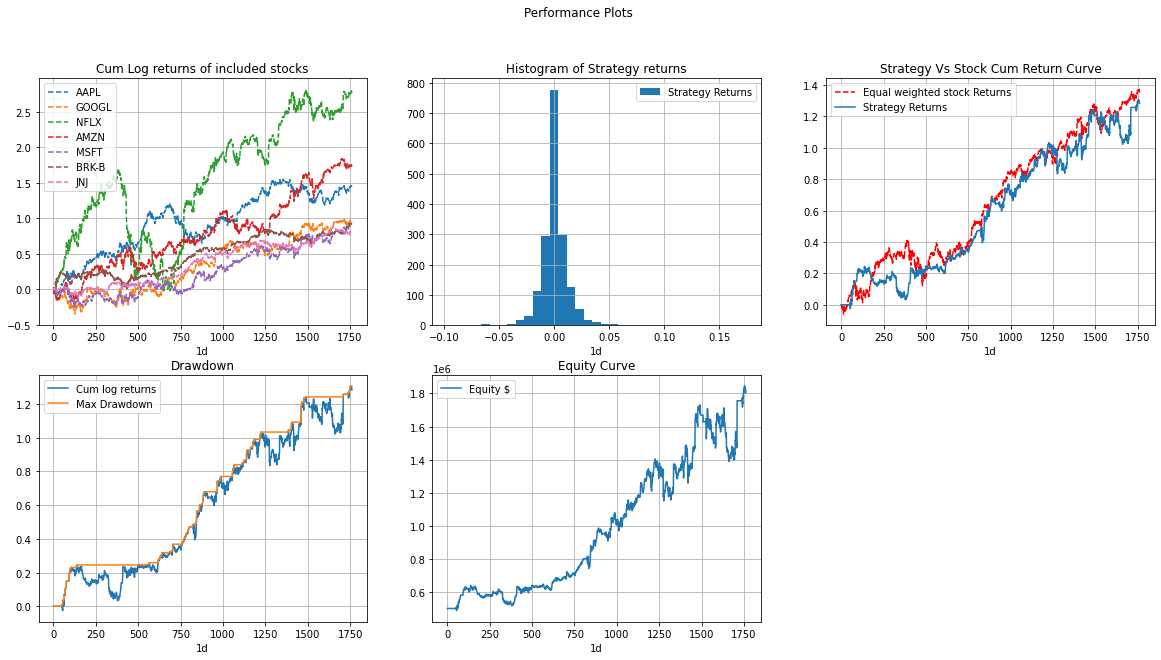

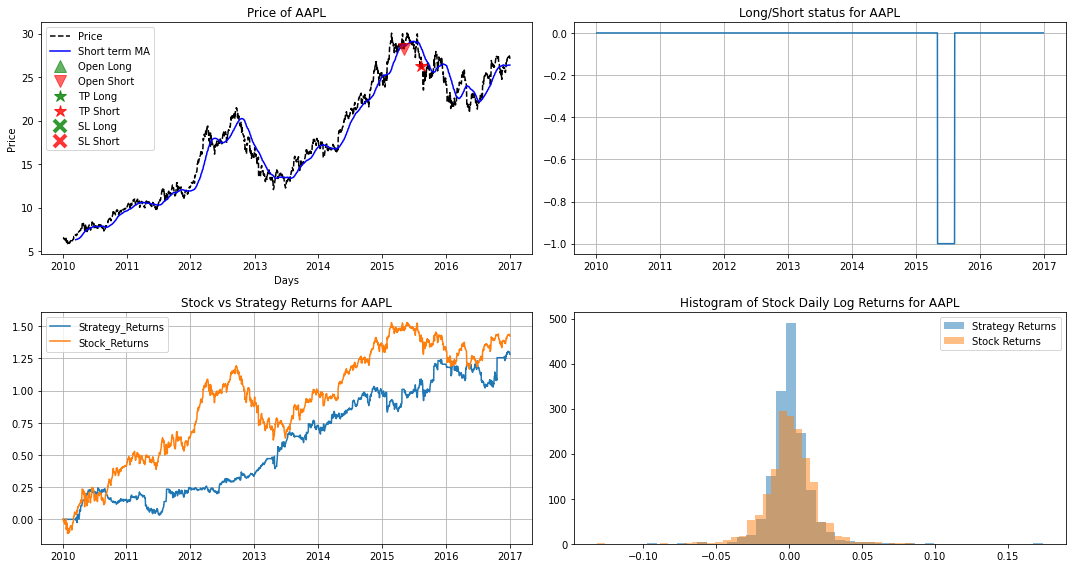

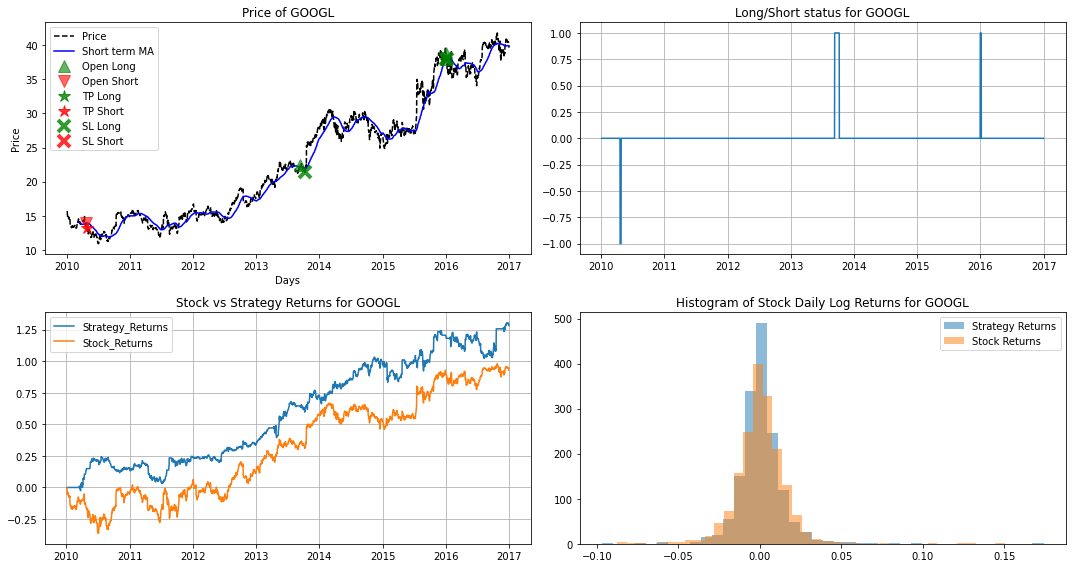

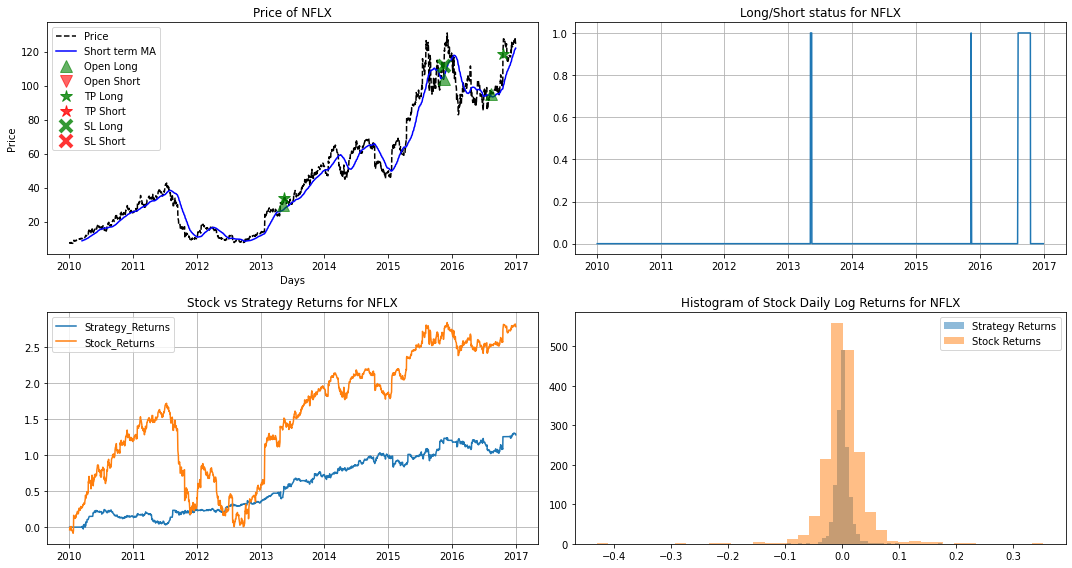

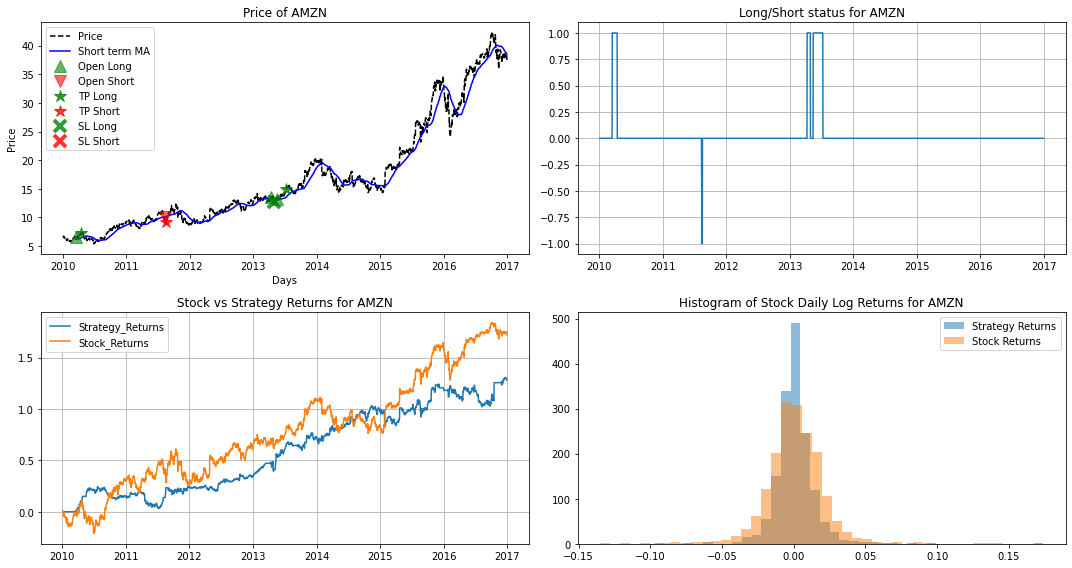

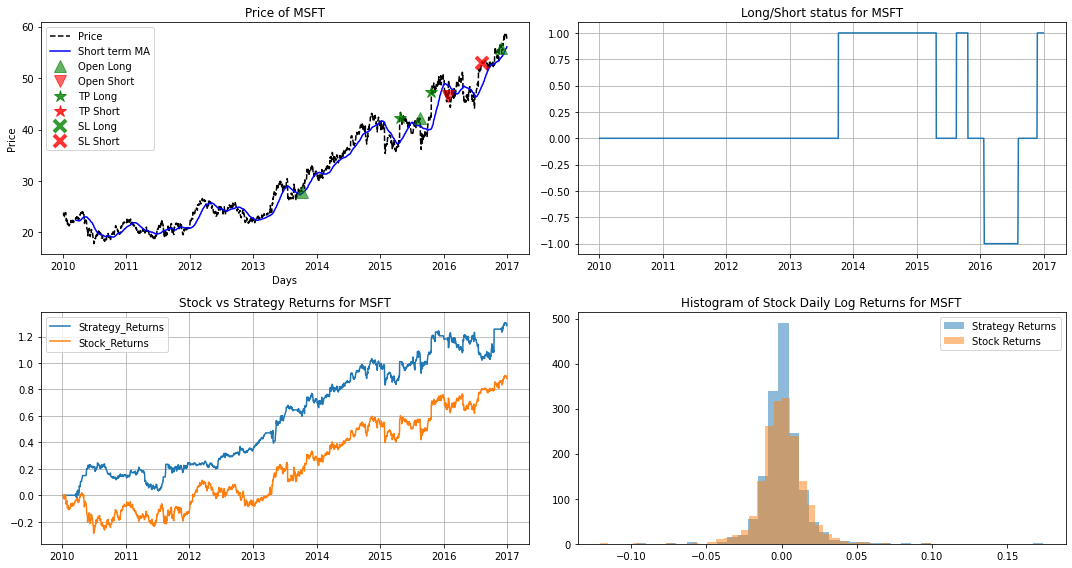

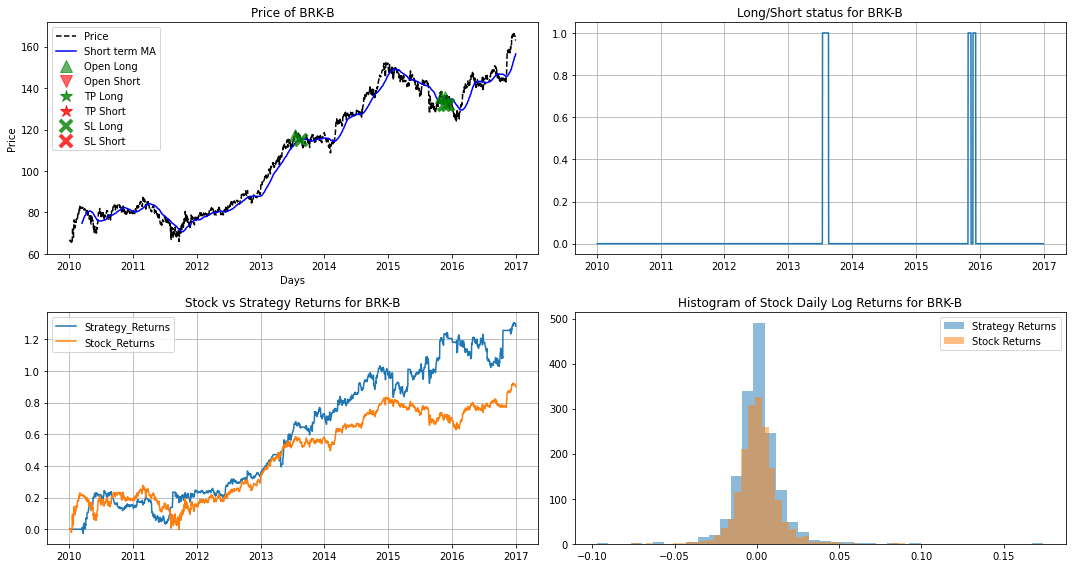

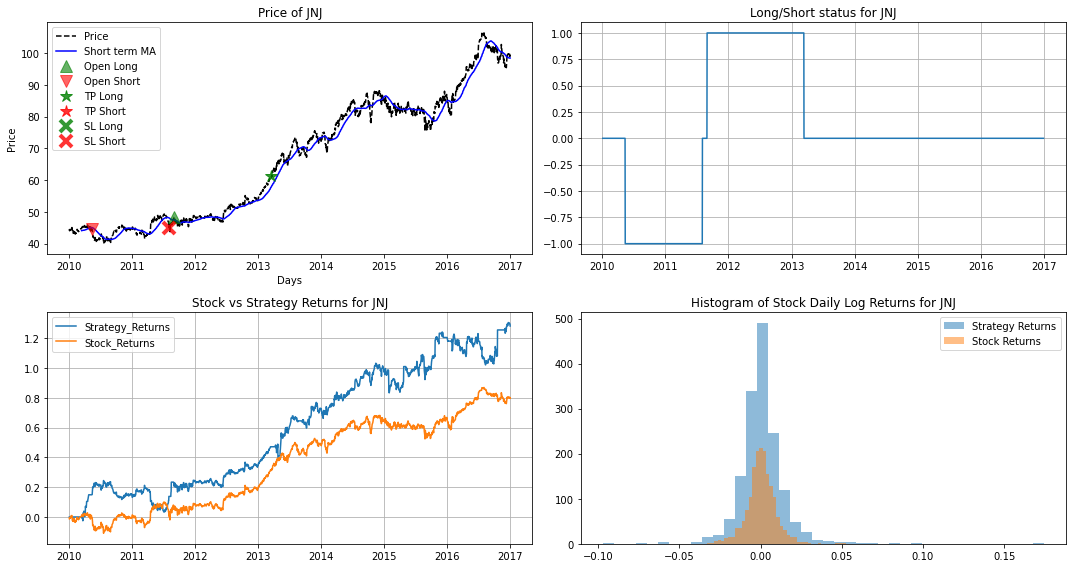

In [107]:
all_res = A.run_strategy()

In [109]:
train_history = {}

primary_trend_window_params =                [50,100]
long_sl_ATR_multiple_params =                [1.5, 2]   # Used for long SL
risk_reward_long_params =                    [1.5, 2, 3]     # Used for long TP
close_n_sma_distance_long_multiple_params =  [2.5, 3]   # Used to determine how close to SMA can be bought
long_rsi_limit_params =                      [70,80]

# Short Params
short_sl_ATR_multiple_params=                [1, 1.5]   # Used for Short SL
risk_reward_short_params=                    [0.7, 1, 1.5, 2]   # Used for Short TP
close_n_sma_distance_short_multiple_params = [0.5, 1]   # Used to determine how close to SMA can be bought
short_rsi_limit_params =                     [20, 30]

all_list = [primary_trend_window_params,long_sl_ATR_multiple_params,risk_reward_long_params,
            close_n_sma_distance_long_multiple_params,long_rsi_limit_params,short_sl_ATR_multiple_params,
           risk_reward_short_params,close_n_sma_distance_short_multiple_params,short_rsi_limit_params]

parameters = list(itertools.product(*all_list))

print(f"{len(parameters)} Available combinations" )

1536 Available combinations


In [110]:
cwd = os.getcwd() 
path = os.path.join(cwd +"\\Tuning" )
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [121]:
load = True

In [122]:
if load:
    all_metrics_df = load_file('Tuning/All_Metrics.pkl')
    all_returns_df = load_file('Tuning/All_Returns.pkl')
    train_history = load_file('Tuning/train_history.pkl')
else:
    all_metrics_df, all_returns_df, train_history = pd.DataFrame,pd.DataFrame,{}

In [123]:
for iteration in tqdm(range(len(parameters))):
    if parameters[iteration] in train_history:
        continue
    else:
        primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= parameters[iteration] # 50 

        smacd_tuning = SMACD_Strategy(  symbol = tickers,
                                        benchmark = benchmark_stock_symbol,
                                        start = start,
                                        end = end,
                                        interval = "1d",
                                        capital = total_capital,
                                        transcation_cost = 0/100,
                                        primary_trend_window = primary_trend_window,
                                        buy_on = buy_on,
                                        long_sl_ATR_multiple = long_sl_ATR_multiple,
                                        risk_reward_long = risk_reward_long,
                                        close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                                        long_rsi_limit= long_rsi_limit,
                                        short_sl_ATR_multiple=short_sl_ATR_multiple,
                                        risk_reward_short=risk_reward_short,
                                        close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                                        short_rsi_limit=short_rsi_limit,
                                        verbose=False,
                                        stock_data_dict = stock_data_dict,
                                        benchmark_df = benchmark_df)
        returns_df= smacd_tuning.run_strategy(tuning = True)
        returns_df["Param"] = f"Combination of param {iteration}"
        returns_df.set_index("Param", inplace=True)
        if iteration== 0:
            all_returns_df = returns_df
        else:
            all_returns_df.loc[f"Combination of param {iteration}"] = returns_df.loc[f"Combination of param {iteration}"]
        train_history[parameters[iteration]] = True

save_file('Tuning/All_Returns.pkl',all_returns_df )
save_file('Tuning/train_history.pkl',train_history )

100%|█████████████████████████████████████████████████████████████████████████| 1536/1536 [00:00<00:00, 1524479.64it/s]


In [141]:
all_returns_df['Params'] = parameters

In [142]:
top_ten_params = all_returns_df.sort_values(['annual_ir','portfolio_calmar_ratio'], ascending =[False, True]).head(10)
top_ten_params

,capital,portfolio_log_returns,portfolio_normal_returns,portfolio_annual_mean_returns,portfolio_annual_regular_std,portfolio_annual_sharpe_ratio,benchmark_annual_regular_returns,annual_ir,portfolio_treynor_ratio,portfolio_calmar_ratio,portfolio_sortino_ratio,Drawdown,delta_valuesmax,trades,Params
Combination of param 525,5.927887e+06,247.281497,1085.577356,0.424557,0.233026,1.821930,0.104824,0.919604,-60.646676,0.291989,3.118223,16.678908,189.0,114.0,"(50, 2, 2, 2.5, 70, 1, 2, 0.5, 30)"
Combination of param 521,5.829806e+06,245.613087,1065.961159,0.421160,0.232955,1.807904,0.104824,0.911481,-72.298284,0.294525,3.093270,16.678800,189.0,114.0,"(50, 2, 2, 2.5, 70, 1, 1.5, 0.5, 30)"
Combination of param 589,5.588672e+06,241.388890,1017.734435,0.412595,0.234292,1.761027,0.104824,0.885630,-58.578980,0.270569,3.046952,17.868927,208.0,116.0,"(50, 2, 2, 3, 70, 1, 2, 0.5, 30)"
Combination of param 517,5.465669e+06,239.163368,993.133771,0.408104,0.232174,1.757754,0.104824,0.881303,-337.383742,0.304408,2.997376,16.678970,189.0,114.0,"(50, 2, 2, 2.5, 70, 1, 1, 0.5, 30)"
Combination of param 585,5.496192e+06,239.720266,999.238392,0.409226,0.234221,1.747177,0.104824,0.877516,-69.735475,0.272875,3.022068,17.868981,208.0,116.0,"(50, 2, 2, 3, 70, 1, 1.5, 0.5, 30)"
Combination of param 426,4.976399e+06,229.785381,895.279891,0.389333,0.220285,1.767404,0.104824,0.867224,6.071139,0.247877,2.353927,25.751385,162.0,64.0,"(50, 2, 1.5, 2.5, 80, 1, 1.5, 1, 20)"
Combination of param 537,5.286763e+06,235.835340,957.352675,0.401414,0.234680,1.710473,0.104824,0.855863,-62.318163,0.309549,2.884741,16.678994,189.0,114.0,"(50, 2, 2, 2.5, 70, 1.5, 1.5, 0.5, 30)"
Combination of param 533,5.199273e+06,234.166591,939.854514,0.398071,0.234608,1.696753,0.104824,0.847744,-75.595090,0.312139,2.860729,16.678785,189.0,114.0,"(50, 2, 2, 2.5, 70, 1.5, 1, 0.5, 30)"
Combination of param 581,5.152928e+06,233.271235,930.585677,0.396281,0.233443,1.697548,0.104824,0.847319,-316.376543,0.281845,2.926468,17.868998,208.0,116.0,"(50, 2, 2, 3, 70, 1, 1, 0.5, 30)"
Combination of param 554,4.854272e+06,227.300635,870.854422,0.384402,0.222836,1.725042,0.104824,0.843693,7.087643,0.250895,2.301102,25.751539,162.0,64.0,"(50, 2, 2, 2.5, 80, 1, 1.5, 1, 20)"


In [144]:
load = False

In [152]:
all_returns_df_in_sample = pd.DataFrame(columns=all_returns_df.columns )
if (load==False):
    for param_no,param in tqdm(enumerate(top_ten_params['Params'])):
        primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= param 
        for i in range(4): # Chnage to get this number automatically
            metrics_start_date = str(datetime.strptime('2016-01-01','%Y-%m-%d').date() + relativedelta(years=i))
            metrics_end_date = str(datetime.strptime('2016-01-01','%Y-%m-%d').date() + relativedelta(years=i+1))
            smacd_tuning = SMACD_Strategy(  symbol = tickers,
                                        benchmark = benchmark_stock_symbol,
                                        start = start,
                                        end = end,
                                        interval = "1d",
                                        capital = total_capital,
                                        transcation_cost = 0/100,
                                        primary_trend_window = primary_trend_window,
                                        buy_on = buy_on,
                                        long_sl_ATR_multiple = long_sl_ATR_multiple,
                                        risk_reward_long = risk_reward_long,
                                        close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                                        long_rsi_limit= long_rsi_limit,
                                        short_sl_ATR_multiple=short_sl_ATR_multiple,
                                        risk_reward_short=risk_reward_short,
                                        close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                                        short_rsi_limit=short_rsi_limit,
                                        verbose=False,
                                        stock_data_dict = stock_data_dict,
                                        benchmark_df = benchmark_df)
            returns_df= smacd_tuning.run_strategy(tuning = True)
            returns_df["Param"] = f"Combination of param {iteration}"
            returns_df.set_index("Param", inplace=True)
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}"] = returns_df.loc[f"Combination of param {iteration}"]
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}","Iteration"] = i
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}","Param"] = top_ten_params.index[param_no]
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}","Period"] = metrics_start_date + "---" + metrics_end_date
    save_file('Tuning/all_returns_df_in_sample.pkl',all_returns_df_in_sample )

all_returns_df_in_sample = load_file('Tuning/all_returns_df_in_sample.pkl')

10it [01:38,  9.84s/it]


### Mean Performance per Period 

In [153]:
all_returns_df_in_sample.groupby(by  = 'Period').mean(numeric_only= True).sort_values(['annual_ir','portfolio_calmar_ratio'], ascending =[False, True])

,capital,portfolio_log_returns,portfolio_normal_returns,portfolio_annual_mean_returns,portfolio_annual_regular_std,portfolio_annual_sharpe_ratio,benchmark_annual_regular_returns,annual_ir,portfolio_treynor_ratio,portfolio_calmar_ratio,portfolio_sortino_ratio,Drawdown,delta_valuesmax,trades,Params,Iteration
Period,,,,,,,,,,,,,,,,
2016-01-01---2017-01-01,5.377786e+06,237.352629,975.557229,0.404514,0.231252,1.749301,0.104824,0.873738,-103.977417,0.283667,2.860486,18.850429,189.3,104.6,NaN,0.0
2017-01-01---2018-01-01,5.377786e+06,237.352629,975.557229,0.404514,0.231252,1.749301,0.104824,0.873738,-103.977417,0.283667,2.860486,18.850429,189.3,104.6,NaN,1.0
2018-01-01---2019-01-01,5.377786e+06,237.352629,975.557229,0.404514,0.231252,1.749301,0.104824,0.873738,-103.977417,0.283667,2.860486,18.850429,189.3,104.6,NaN,2.0
2019-01-01---2020-01-01,5.377786e+06,237.352629,975.557229,0.404514,0.231252,1.749301,0.104824,0.873738,-103.977417,0.283667,2.860486,18.850429,189.3,104.6,NaN,3.0


### Mean Performance per Year 

Choose best strat based on the smallest std of performance 

In [154]:
best_of_the_best = all_returns_df_in_sample.groupby(by  = 'Param').std(numeric_only= True).sort_values(['annual_ir','portfolio_calmar_ratio'], ascending =[True, False])
best_of_the_best

,capital,portfolio_log_returns,portfolio_normal_returns,portfolio_annual_mean_returns,portfolio_annual_regular_std,portfolio_annual_sharpe_ratio,benchmark_annual_regular_returns,annual_ir,portfolio_treynor_ratio,portfolio_calmar_ratio,portfolio_sortino_ratio,Drawdown,delta_valuesmax,trades,Params,Iteration
Param,,,,,,,,,,,,,,,,
Combination of param 426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994
Combination of param 585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.290994


# Results of Strategy with Best Params

In [157]:
int(best_of_the_best.index[0].split(" ")[-1])

426

In [160]:
best_params = parameters[int(best_of_the_best.index[0].split(" ")[-1])]
primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= best_params # 50 
print(f'primary_trend_window = {primary_trend_window},\nlong_sl_ATR_multiple = {long_sl_ATR_multiple},\nrisk_reward_long = {risk_reward_long},\nclose_n_sma_distance_long_multiple = {close_n_sma_distance_long_multiple},\nlong_rsi_limit = {long_rsi_limit},\nshort_sl_ATR_multiple = {short_sl_ATR_multiple},\nrisk_reward_short = {risk_reward_short},\nclose_n_sma_distance_short_multiple = {close_n_sma_distance_short_multiple},\nshort_rsi_limit = {short_rsi_limit},')

primary_trend_window = 50,
long_sl_ATR_multiple = 2,
risk_reward_long = 1.5,
close_n_sma_distance_long_multiple = 2.5,
long_rsi_limit = 80,
short_sl_ATR_multiple = 1,
risk_reward_short = 1.5,
close_n_sma_distance_short_multiple = 1,
short_rsi_limit = 20,


# Data Visualisation of Returns


---------Open Long----------
Bought 76138 shares of AMZN at 6.6 per share worth 499998.2 $
Total quantity for AMZN is 76138
Date :2010-03-17 | Realised Balance: 1.8
Sold 76138 shares of AMZN at 7.0 per share worth 533575.1 $
Total quantity for AMZN is 0
Date :2010-04-13 | Realised Balance: 533576.9
---------Close Long at TP----------

---------Open Short----------
Sold 6668 shares of BRK-B at 80.0 per share worth 533506.7 $
Total quantity for BRK-B is -6668
Date :2010-04-20 | Realised Balance: 1067083.6
Bought 6668 shares of BRK-B at 77.2 per share worth 514569.5 $
Total quantity for BRK-B is 0
Date :2010-04-28 | Realised Balance: 552514.0
---------Close Short at TP----------

---------Open Short----------
Sold 84051 shares of AMZN at 6.6 per share worth 552509.3 $
Total quantity for AMZN is -84051
Date :2010-05-13 | Realised Balance: 1105023.3
Bought 84051 shares of AMZN at 6.2 per share worth 523595.7 $
Total quantity for AMZN is 0
Date :2010-05-19 | Realised Balance: 581427.6
-----

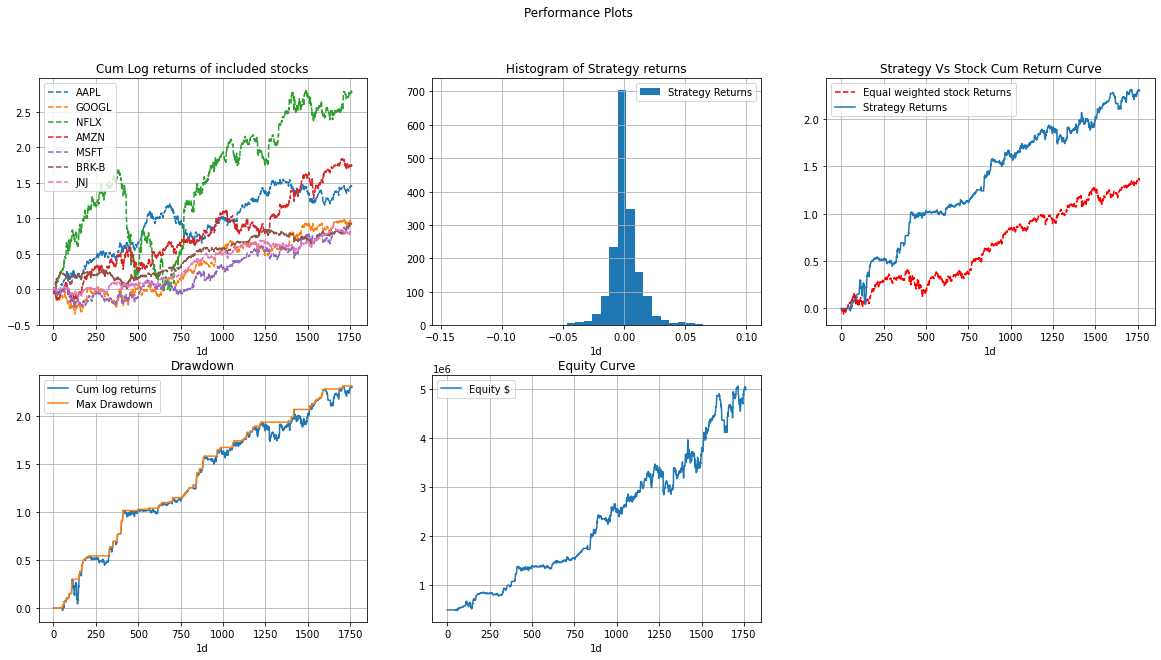

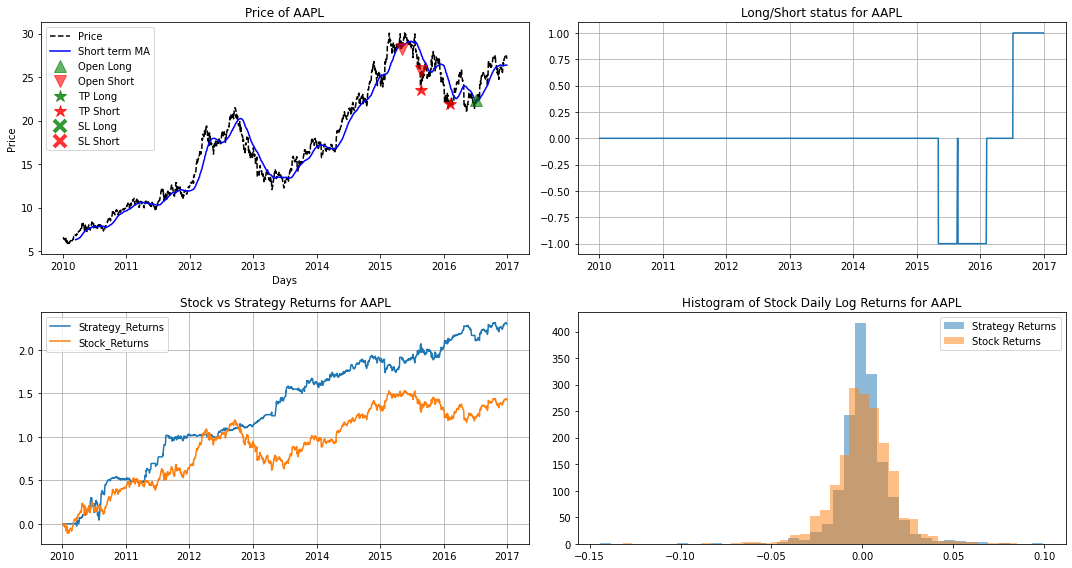

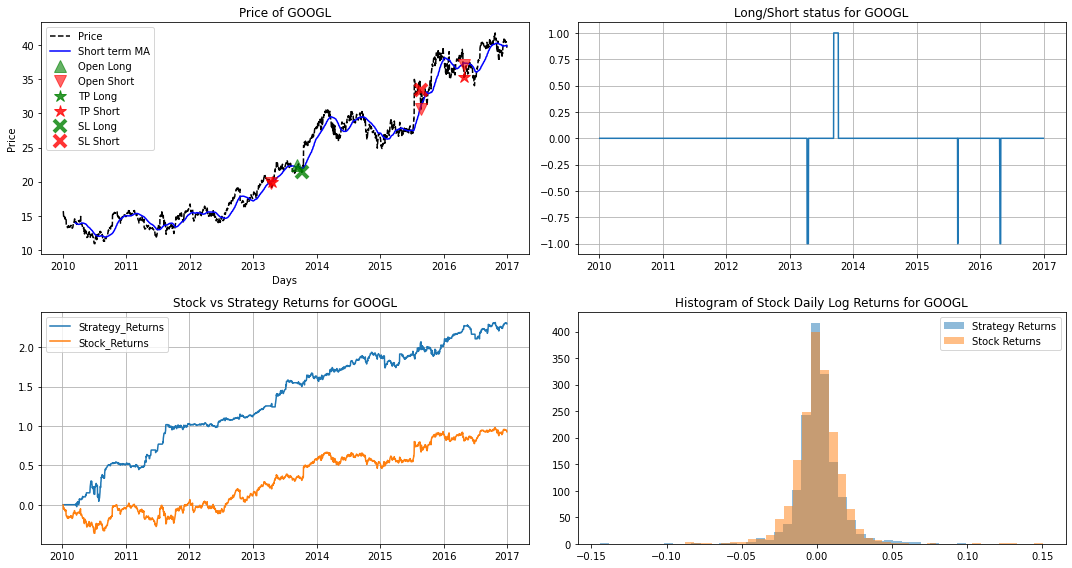

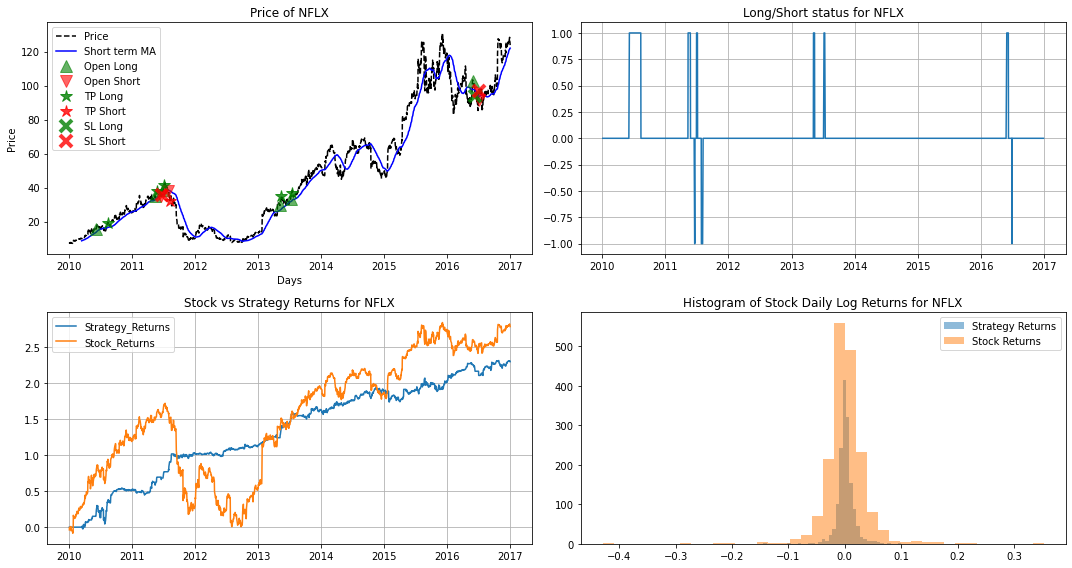

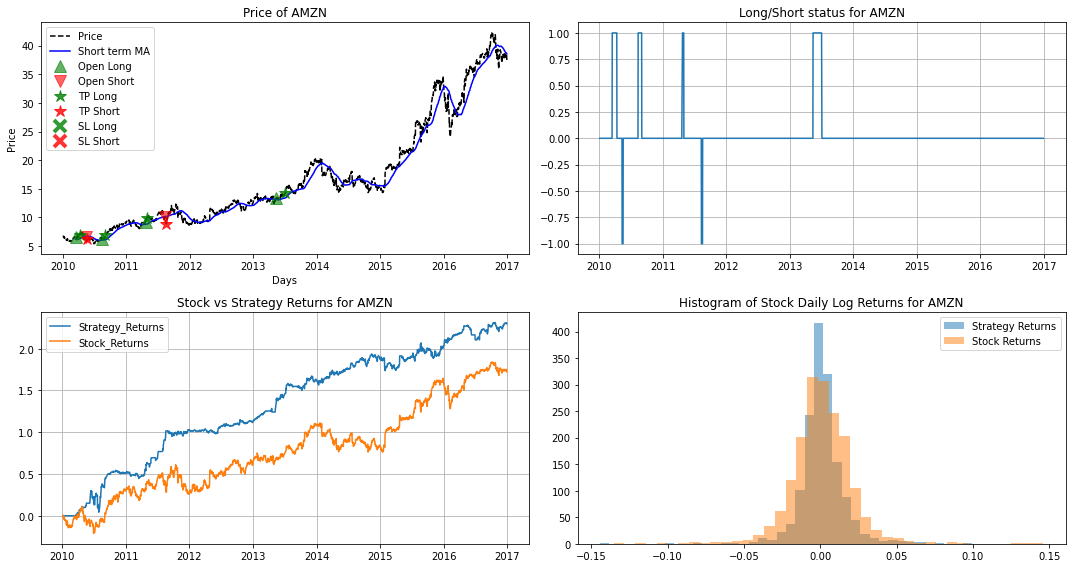

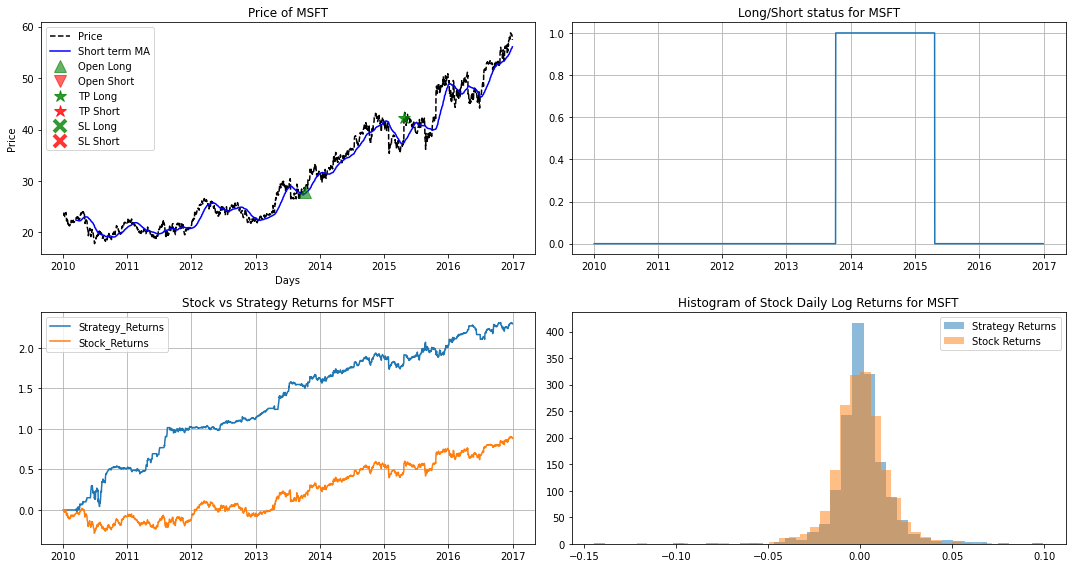

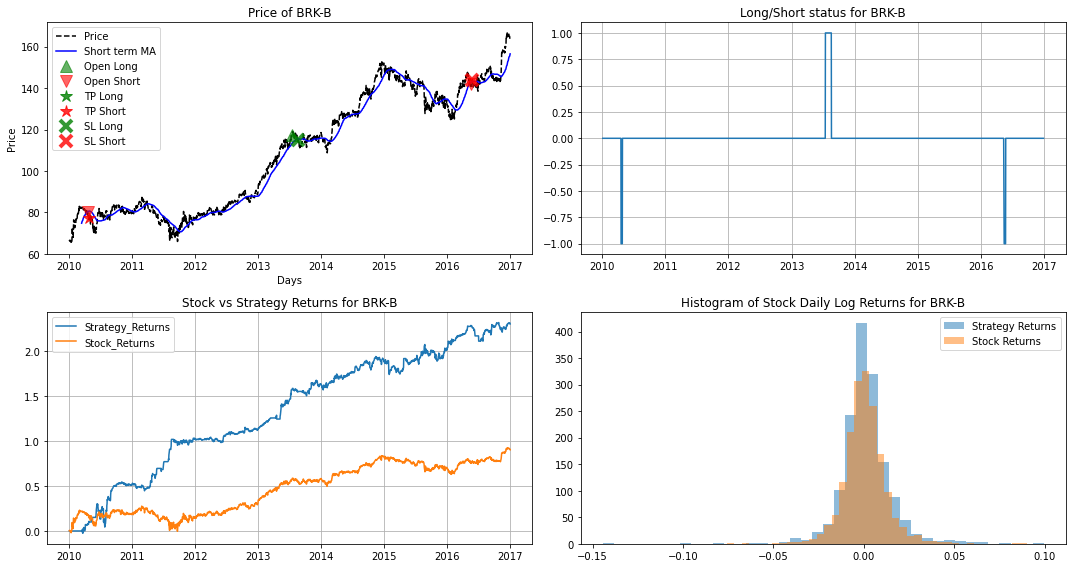

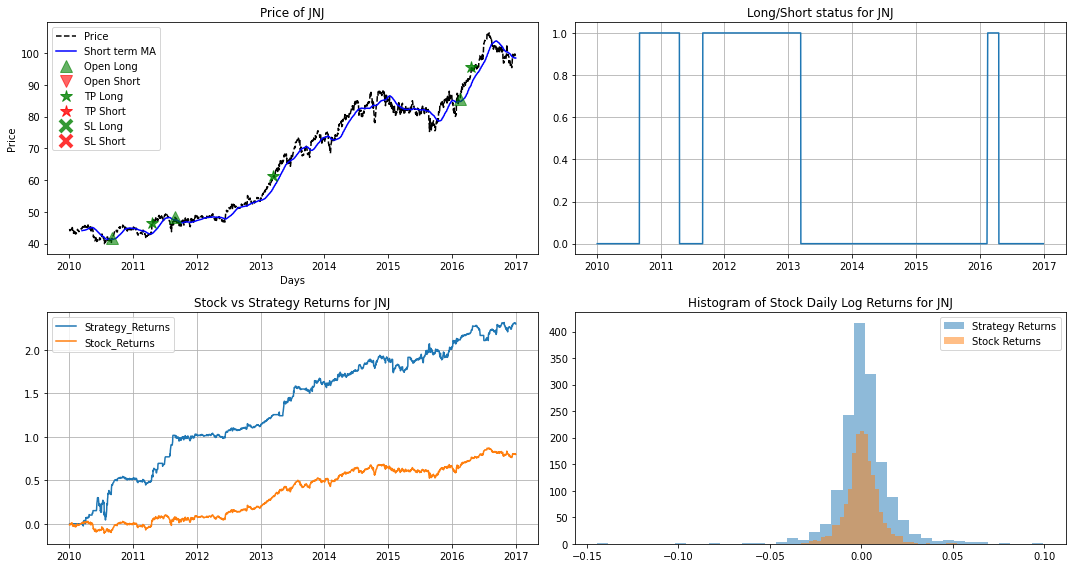

In [167]:
A = SMACD_Strategy(symbol = tickers,
                benchmark = benchmark_stock_symbol,
                start = start,
                end = end,
                interval = "1d",
                capital = total_capital,
                transcation_cost = 0/100,
                primary_trend_window = primary_trend_window,
                buy_on = buy_on,
                long_sl_ATR_multiple = long_sl_ATR_multiple,
                risk_reward_long = risk_reward_long,
                close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                long_rsi_limit= long_rsi_limit,
                short_sl_ATR_multiple=short_sl_ATR_multiple,
                risk_reward_short=risk_reward_short,
                close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                short_rsi_limit=short_rsi_limit,
                verbose=True,
                stock_data_dict = stock_data_dict,
                benchmark_df = benchmark_df)
_ = A.run_strategy()